In [1]:
from pydataxm import *                           #Se realiza la importación de las librerias necesarias para ejecutar                        
from pydataxm.pydataxm import ReadDB as apiXM 
import datetime as dt                            
import pandas as pd
from pathlib import Path
import os

In [2]:
s_path=Path.cwd()
s_prt_path=s_path.parent
s_pathPrint=s_path.joinpath('Print')

objetoAPI = pydataxm.ReadDB()                    #Se almacena el servicio en el nombre objetoAPI
df =objetoAPI.get_collections()   

In [52]:
FechaIni=dt.date(2020, 1, 1)
FechaFin=dt.date(2025, 11, 30)

# FechaIni=dt.date(2023, 1, 1)
# FechaFin=dt.date(2025, 6, 15)

In [53]:
# Unit kWh
df_PB= apiXM.request_data(pydataxm.ReadDB(),    #Se indica el objeto que contiene el serivicio
                        "PrecBolsNaci",                #Se indica el nombre de la métrica tal como se llama en el campo metricID
                        "Sistema",                 #Campo que indica si es Sistema, Agente, Recurso, Comercializador
                        FechaIni,       #Corresponde a la fecha inicial de la consulta
                        FechaFin)      #Corresponde a la fecha final de la consulta
# df_Comb.rename(columns={'Values_code':'planta'},inplace=True)
# df_Comb=df_Comb.fillna(0)

# Unit kWh
df_PEA= apiXM.request_data(pydataxm.ReadDB(),    #Se indica el objeto que contiene el serivicio
                        "PrecEscaAct",                #Se indica el nombre de la métrica tal como se llama en el campo metricID
                        "Sistema",                 #Campo que indica si es Sistema, Agente, Recurso, Comercializador
                        FechaIni,       #Corresponde a la fecha inicial de la consulta
                        FechaFin)      #Corresponde a la fecha final de la consulta
df_PEA.rename(columns={'Value':'PEA'},inplace=True)

In [67]:
df_PBIni=df_PB.copy()

for i in range(1,25):
    if i<10:
        df_PBIni = df_PBIni.rename(columns={f'Values_Hour0{i}': i})
    else:
        df_PBIni = df_PBIni.rename(columns={f'Values_Hour{i}': i})


df_PBIni = df_PBIni.melt(id_vars=['Date'], value_vars=list(range(1, 25)), var_name='periodo', value_name='PB')
df_CE=df_PBIni.merge(df_PEA,left_on=['Date'],right_on=['Date'], how='left')[['Date','periodo','PB','PEA']]
df_CE['PEA']=df_CE['PEA'].fillna(0)
df_CE['Con_Esc'] = (df_CE['PB'] > df_CE['PEA']).astype(int)
df_CE=df_CE.groupby(['Date'])[['Con_Esc']].sum()
df_CE=df_CE.reset_index()
df_CE['Con_Esc_Flag'] = (df_CE['Con_Esc'] > 0).astype(int)

In [20]:
df_CE.to_csv(s_pathPrint.joinpath('CE.csv'))

In [68]:
# Consutlar combustible
df_Comb= apiXM.request_data(pydataxm.ReadDB(),    #Se indica el objeto que contiene el serivicio
                        "ConsCombustibleMBTU",                #Se indica el nombre de la métrica tal como se llama en el campo metricID
                        "Recurso",                 #Campo que indica si es Sistema, Agente, Recurso, Comercializador
                        FechaIni,       #Corresponde a la fecha inicial de la consulta
                        FechaFin)      #Corresponde a la fecha final de la consulta
df_Comb.rename(columns={'Values_code':'planta'},inplace=True)
df_Comb=df_Comb.fillna(0)

In [69]:
df_CombIni=df_Comb.copy()
df_CombIni=df_CombIni[(df_CombIni['planta'].isin(['TBST','TBQ3','TBQ4','TCD2','TCD1','TCDT']))]

df_CombIni['TotalDia']=0
l_per=[]
for i in range(1,25):
    if i<10:
        l_per.append('Values_Hour0' + str(i))
    else:
        l_per.append('Values_Hour' + str(i))


for col in l_per:
    df_CombIni['TotalDia']=df_CombIni['TotalDia']+df_CombIni[col]

df_CombIni=df_CombIni[['Date','planta','TotalDia']]
df_CombIni['TotalDia']=round(df_CombIni['TotalDia']/1000,2)

df_CombIni.to_csv(s_pathPrint.joinpath('Combustible.csv'))

In [70]:
# TBST TBQ3 TBQ4 TCD2 TCD1 TCDT
df_pltTB=df_CombIni[(df_CombIni['planta'].isin(['TBST','TBQ3','TBQ4']))]
df_pltTB=df_pltTB.groupby(['Date'])[['TotalDia']].sum().round(2)
df_pltTB=df_pltTB.reset_index()
df_pltTB=df_pltTB.rename(columns={f'TotalDia': 'TEBSA'})
df_pltTB.to_csv(s_pathPrint.joinpath('TB.csv'))

# TBST TBQ3 TBQ4 TCD2 TCD1 TCDT
df_pltTC=df_CombIni[(df_CombIni['planta'].isin(['TCD1','TCD2','TCDT']))]
df_pltTC=df_pltTC.groupby(['Date'])[['TotalDia']].sum().round(2)
df_pltTC=df_pltTC.reset_index()
df_pltTC=df_pltTC.rename(columns={f'TotalDia': 'TC'})
df_pltTC.to_csv(s_pathPrint.joinpath('TC.csv'))

In [72]:
df_data=df_CE.merge(df_pltTB,left_on=['Date'],right_on=['Date'], how='left')[['Date','Con_Esc_Flag','TEBSA']]
df_data['TEBSA']=df_data['TEBSA'].fillna(0)
df_data=df_data.merge(df_pltTC,left_on=['Date'],right_on=['Date'], how='left')[['Date','Con_Esc_Flag','TEBSA','TC']]
df_data['TC']=df_data['TC'].fillna(0)
df_data['TB+TC']=(df_data['TEBSA']+df_data['TC']).round(2)
df_data.tail(5)

,Date,Con_Esc_Flag,TEBSA,TC,TB+TC
2156,2025-11-26,1,71.20,58.47,129.67
2157,2025-11-27,1,83.82,49.09,132.91
2158,2025-11-28,1,58.84,58.92,117.76
2159,2025-11-29,1,52.23,38.23,90.46
2160,2025-11-30,1,76.37,19.66,96.03


In [80]:
df_data1=df_data.copy()
df_data1['TEBSA']=df_data1['TEBSA']/1.02
df_data1['TC']=df_data1['TC']/1.01
df_data1['TPL']=(df_data1['TEBSA']+df_data1['TC']).round(2)
df_data1=df_data1[['Date','TPL']]
df_data1.head(5)
# df_data1.to_csv('ConsumoHistorico.csv')

,Date,TPL
0,2020-01-01,69.06
1,2020-01-02,116.42
2,2020-01-03,91.92
3,2020-01-04,81.71
4,2020-01-05,67.35


0. Preparación básica (recomendado al inicio del notebook

In [81]:
import pandas as pd
import matplotlib.pyplot as plt

# Asegurar tipos correctos y orden temporal
df = df_data1.copy()
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

df

,Date,TPL
0,2020-01-01,69.06
1,2020-01-02,116.42
2,2020-01-03,91.92
3,2020-01-04,81.71
4,2020-01-05,67.35
...,...,...
2156,2025-11-26,127.70
2157,2025-11-27,130.78
2158,2025-11-28,116.02
2159,2025-11-29,89.06


1. Gráfica del comportamiento del consumo en todo el horizonte

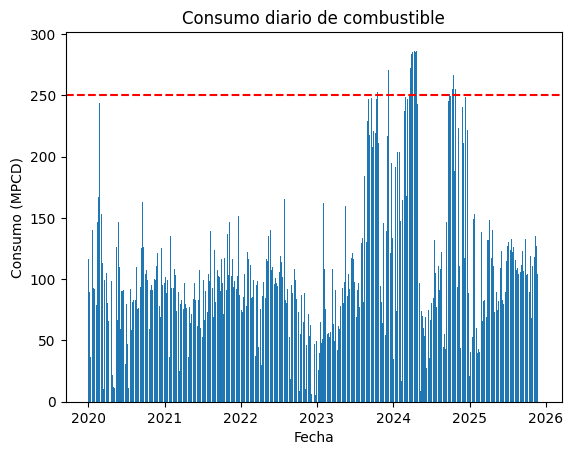

In [82]:
plt.figure()
plt.bar(df['Date'], df['TPL'])
plt.axhline(250, linestyle='--',color='red')
plt.xlabel('Fecha')
plt.ylabel('Consumo (MPCD)')
plt.title('Consumo diario de combustible')
plt.show()



# 2. Frecuencia y duración de consumo ≥ 250 MPCD (serie original)

## 2.1 Indicador lógico y frecuencia

In [83]:
df['consumo_ge_250'] = df['TPL'] >= 250

frecuencia_250 = df['consumo_ge_250'].sum()
frecuencia_250

87

## 2.2 Duración de periodos continuos ≥ 250 MPCD

In [85]:
df['evento_250'] = (
    (df['consumo_ge_250']) &
    (~df['consumo_ge_250'].shift(fill_value=False))
).cumsum()

eventos_250 = (
    df[df['consumo_ge_250']]
    .groupby('evento_250')
    .agg(
        fecha_inicio=('Date', 'min'),
        fecha_fin=('Date', 'max'),
        duracion_dias=('Date', 'count')
    )
    .reset_index()
)

eventos_250.to_csv('DataDías.csv')

# 3. Promedio móvil de 3 días y análisis ≥ 250 MPCD

## 3.1 Cálculo del promedio móvil 3 días

In [86]:
df['TPL_MA_3D'] = df['TPL'].rolling(window=3, min_periods=3).mean()

## 3.2 Periodos y duración con MA(3) ≥ 250

In [87]:
# Condición sobre MA3
df['MA3_ge_250'] = df['TPL_MA_3D'] >= 250

# Evento solo cuando pasa de False -> True
df['evento_MA3'] = (
    (df['MA3_ge_250']) &
    (~df['MA3_ge_250'].shift(fill_value=False))
).cumsum()

# Tabla de eventos MA3
eventos_MA3 = (
    df[df['MA3_ge_250']]
    .groupby('evento_MA3')
    .agg(
        fecha_inicio=('Date', 'min'),
        fecha_fin=('Date', 'max'),
        duracion_dias=('Date', 'count')
    )
    .reset_index()
)

eventos_MA3
eventos_MA3.to_csv('DataDías.csv')


## 3.3 Gráfica MA(3)

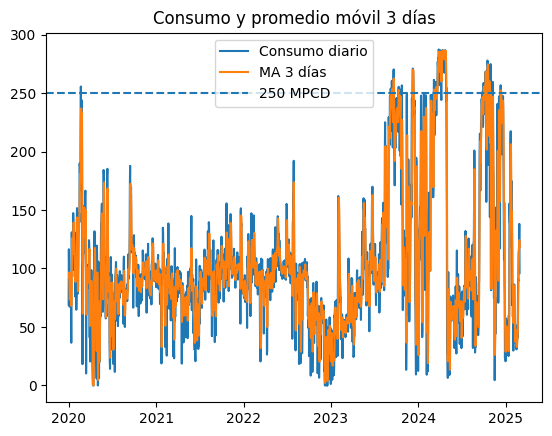

In [41]:
plt.figure()
plt.plot(df['Date'], df['TPL'], label='Consumo diario')
plt.plot(df['Date'], df['TPL_MA_3D'], label='MA 3 días')
plt.axhline(250, linestyle='--', label='250 MPCD')
plt.legend()
plt.title('Consumo y promedio móvil 3 días')
plt.show()


# 4. Promedio móvil de 2 días y análisis ≥ 250 MPCD

## 4.1 Cálculo MA(2)

In [88]:
df['TPL_MA_2D'] = df['TPL'].rolling(window=2, min_periods=2).mean()

## 4.2 Periodos y duración con MA(2) ≥ 250

In [90]:
# Condición sobre MA2
df['MA2_ge_250'] = df['TPL_MA_2D'] >= 250

# Evento solo cuando pasa de False -> True
df['evento_MA2'] = (
    (df['MA2_ge_250']) &
    (~df['MA2_ge_250'].shift(fill_value=False))
).cumsum()

# Tabla de eventos MA2
eventos_MA2 = (
    df[df['MA2_ge_250']]
    .groupby('evento_MA2')
    .agg(
        fecha_inicio=('Date', 'min'),
        fecha_fin=('Date', 'max'),
        duracion_dias=('Date', 'count')
    )
    .reset_index()
)

eventos_MA2.to_csv('DataDías.csv')



## 4.3 Gráfica MA(2)

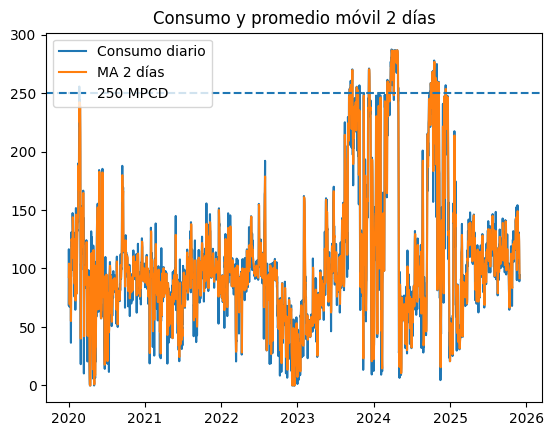

In [91]:
plt.figure()
plt.plot(df['Date'], df['TPL'], label='Consumo diario')
plt.plot(df['Date'], df['TPL_MA_2D'], label='MA 2 días')
plt.axhline(250, linestyle='--', label='250 MPCD')
plt.legend()
plt.title('Consumo y promedio móvil 2 días')
plt.show()


# 5. Días continuos con consumo ≤ 250 MPCD

In [44]:
df['ge_250'] = df['TPL'] >= 250

df['evento_ge_250'] = (
    df['ge_250'] & ~df['ge_250'].shift(fill_value=False)
).cumsum()

rachas_ge_250 = (
    df[df['ge_250']]
    .groupby('evento_ge_250')
    .agg(
        fecha_inicio=('Date', 'min'),
        fecha_fin=('Date', 'max'),
        duracion_dias=('Date', 'count')
    )
    .reset_index()
)

rachas_ge_250

,evento_ge_250,fecha_inicio,fecha_fin,duracion_dias
0,1,2020-02-21,2020-02-21,1
1,2,2023-09-08,2023-09-09,2
2,3,2023-09-13,2023-09-14,2
3,4,2023-09-20,2023-09-21,2
4,5,2023-10-11,2023-10-12,2
5,6,2023-10-15,2023-10-15,1
6,7,2023-10-17,2023-10-18,2
7,8,2023-10-25,2023-10-25,1
8,9,2023-11-15,2023-11-15,1
9,10,2023-12-09,2023-12-12,4


## Código anteior

In [25]:
df_data1=df_data.copy()

# Filtro 1 generación térmica mínima
# Definir las fechas de inicio y fin a eliminar
fecha_inicio = dt.date(2024, 4, 10)
fecha_fin = dt.date(2024, 4, 30)
df_data1 = df_data1[~((df_data1['Date'] >= pd.to_datetime(fecha_inicio)) & (df_data1['Date'] <= pd.to_datetime(fecha_fin)))]
df_data1 = df_data1.reset_index(drop=True)

# Filtro 2 generación térmica mínima
# Definir las fechas de inicio y fin a eliminar
fecha_inicio = dt.date(2024, 9, 29)
fecha_fin = dt.date(2024, 11, 29)
df_data1 = df_data1[~((df_data1['Date'] >= pd.to_datetime(fecha_inicio)) & (df_data1['Date'] <= pd.to_datetime(fecha_fin)))]
df_data1 = df_data1.reset_index(drop=True)

df_data1.to_csv(s_pathPrint.joinpath('DataCombFinal.csv'))

### Probailidad de que TEBSA supere 155 GBTUD

In [37]:
df_data1=df_data.copy()

Total Registros: 486
Número de veces que TEBSA supera 155: 106
Probabilidad de que TEBSA supere 155: 0.2181


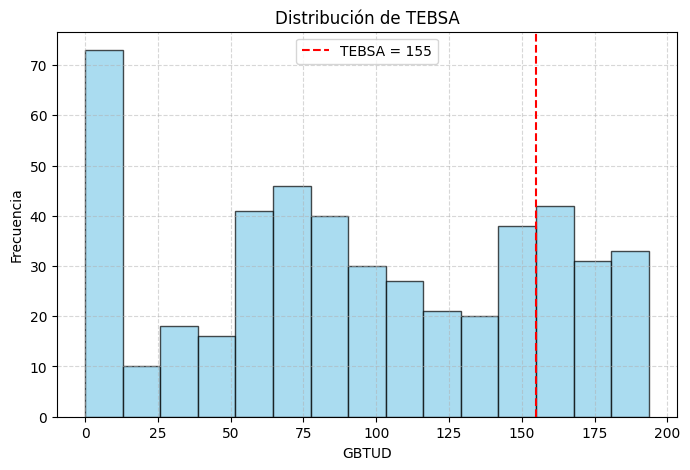

In [43]:
df_TEBSA150=df_data1.copy()

# Calcular la probabilidad y el número de veces que TEBSA supera 155
num_supera_155 = (df_TEBSA150['TEBSA'] > 155).sum()
total_registros = len(df_TEBSA150)
prob_supera_155 = num_supera_155 / total_registros if total_registros > 0 else 0

print(f"Total Registros: {total_registros}")
print(f"Número de veces que TEBSA supera 155: {num_supera_155}")
print(f"Probabilidad de que TEBSA supere 155: {prob_supera_155:.4f}")

# Gráfica de distribución
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(df_TEBSA150['TEBSA'], bins=15, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(155, color='red', linestyle='--', label='TEBSA = 155')
plt.title('Distribución de TEBSA')
plt.xlabel('GBTUD')
plt.ylabel('Frecuencia')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

### Probailidad de que TEBSA supere 155 GBTUD en condición normal

Total Registros: 398
Número de veces que TEBSA supera 155: 58
Probabilidad de que TEBSA supere 155: 0.1457


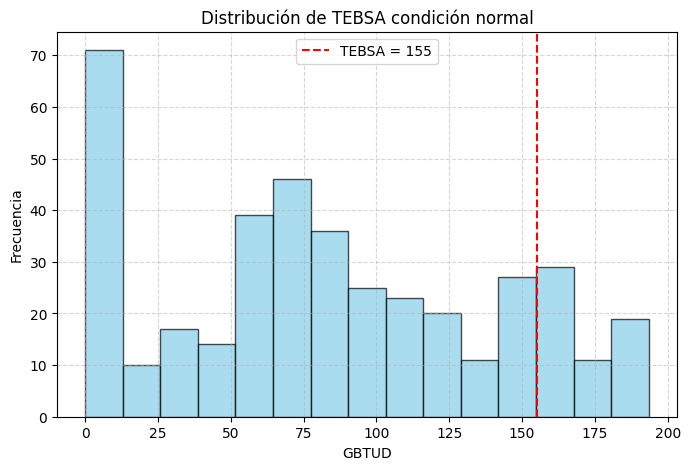

In [40]:
df_TEBSA150=df_data1[(df_data1['Con_Esc_Flag']==0)]

# Calcular la probabilidad y el número de veces que TEBSA supera 155
num_supera_155 = (df_TEBSA150['TEBSA'] > 155).sum()
total_registros = len(df_TEBSA150)
prob_supera_155 = num_supera_155 / total_registros if total_registros > 0 else 0

print(f"Total Registros: {total_registros}")
print(f"Número de veces que TEBSA supera 155: {num_supera_155}")
print(f"Probabilidad de que TEBSA supere 155: {prob_supera_155:.4f}")

# Gráfica de distribución
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(df_TEBSA150['TEBSA'], bins=15, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(155, color='red', linestyle='--', label='TEBSA = 155')
plt.title('Distribución de TEBSA condición normal')
plt.xlabel('GBTUD')
plt.ylabel('Frecuencia')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

### Probailidad de que TEBSA supere 155 GBTUD en condición de escacez

Total Registros: 26
Número de veces que TEBSA supera 155: 13
Probabilidad de que TEBSA supere 155: 0.5000


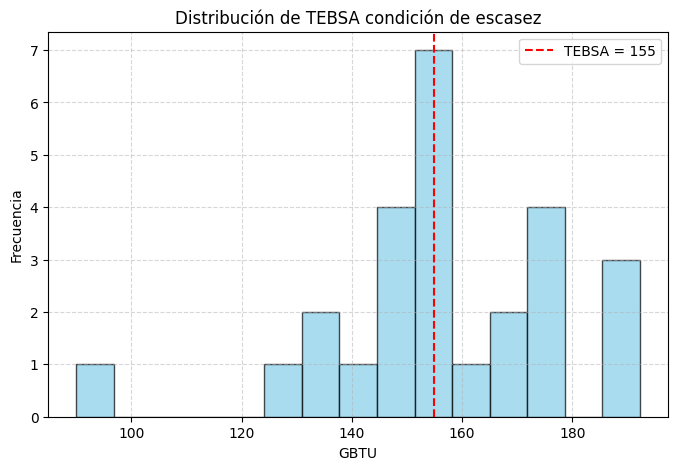

In [ ]:
df_TEBSA150=df_data1[(df_data1['Con_Esc_Flag']==1)]

# Calcular la probabilidad y el número de veces que TEBSA supera 155
num_supera_155 = (df_TEBSA150['TEBSA'] > 155).sum()
total_registros = len(df_TEBSA150)
prob_supera_155 = num_supera_155 / total_registros if total_registros > 0 else 0

print(f"Total Registros: {total_registros}")
print(f"Número de veces que TEBSA supera 155: {num_supera_155}")
print(f"Probabilidad de que TEBSA supere 155: {prob_supera_155:.4f}")

# Gráfica de distribución
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(df_TEBSA150['TEBSA'], bins=15, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(155, color='red', linestyle='--', label='TEBSA = 155')
plt.title('Distribución de TEBSA condición de escasez')
plt.xlabel('GBTU')
plt.ylabel('Frecuencia')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

### Probailidad de que TEBSA + TC supere 255 GBTUD

Total Registros: 486
Número de veces que TB+TC supera 255: 70
Probabilidad de que TB+TC supere 255: 0.1440


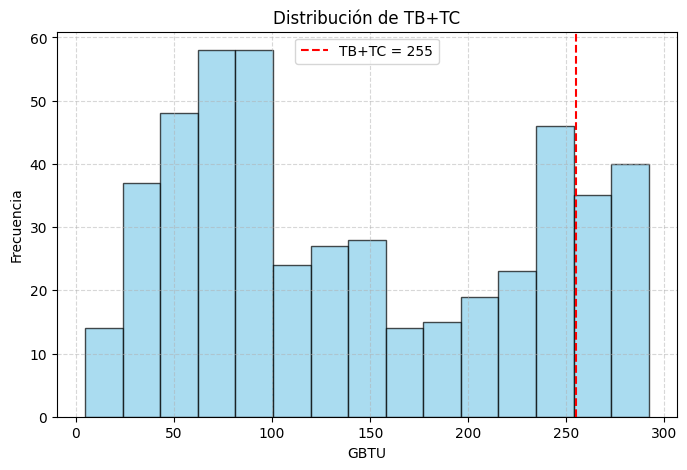

In [42]:
df_TEBSA_TC=df_data1.copy()

# Calcular la probabilidad y el número de veces que TEBSA + TC supera 255
num_supera_255 = (df_TEBSA_TC['TB+TC'] > 255).sum()
total_registros = len(df_TEBSA_TC)
prob_supera_255= num_supera_255 / total_registros if total_registros > 0 else 0

print(f"Total Registros: {total_registros}")
print(f"Número de veces que TB+TC supera 255: {num_supera_255}")
print(f"Probabilidad de que TB+TC supere 255: {prob_supera_255:.4f}")

# Gráfica de distribución
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(df_TEBSA_TC['TB+TC'], bins=15, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(255, color='red', linestyle='--', label='TB+TC = 255')
plt.title('Distribución de TB+TC')
plt.xlabel('GBTU')
plt.ylabel('Frecuencia')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

### Probailidad de que TEBSA + TC supere 255 GBTUD en condición normal

Total Registros: 468
Número de veces que TB+TC supera 255: 70
Probabilidad de que TB+TC supere 255: 0.1496


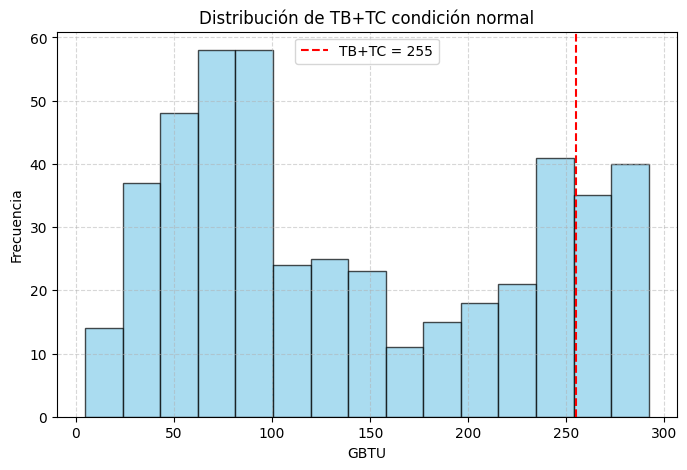

In [ ]:
df_TEBSA_TC=df_data1[(df_data1['Con_Esc_Flag']==0)]

# Lectura de datos de enrtrada para el cálculo
s_parentpath=Path('C:\Alejo\EstadísticasConsumo')
filepath=s_parentpath.joinpath(s_parentpath,'DatosPrueba.xlsx')

# Carga del nivel probabilístico del embalse
sheet_name='Fechas'
df_Fecha=pd.read_excel(filepath, header=0,sheet_name=sheet_name)

# Eliminar del dataframe df_TEBSA_TC las fechas que están en la columna Fecha de df_Fecha
df_TEBSA_TC = df_TEBSA_TC[~df_TEBSA_TC['Date'].isin(df_Fecha['Fecha'])]
df_TEBSA_TC = df_TEBSA_TC.reset_index(drop=True)

df_TEBSA_TC.to_csv(s_pathPrint.joinpath('DataTB_TC.csv'))

# Calcular la probabilidad y el número de veces que TEBSA supera 155
num_supera_255 = (df_TEBSA_TC['TB+TC'] > 255).sum()
total_registros = len(df_TEBSA_TC)
prob_supera_255= num_supera_255 / total_registros if total_registros > 0 else 0

print(f"Total Registros: {total_registros}")
print(f"Número de veces que TB+TC supera 255: {num_supera_255}")
print(f"Probabilidad de que TB+TC supere 255: {prob_supera_255:.4f}")

# Gráfica de distribución
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(df_TEBSA_TC['TB+TC'], bins=15, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(255, color='red', linestyle='--', label='TB+TC = 255')
plt.title('Distribución de TB+TC condición normal')
plt.xlabel('GBTU')
plt.ylabel('Frecuencia')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

### Probailidad de que TEBSA + TC supere 255 GBTUD en condición de escacez

Total Registros: 26
Número de veces que TB+TC supera 255: 6
Probabilidad de que TB+TC supere 255: 0.2308


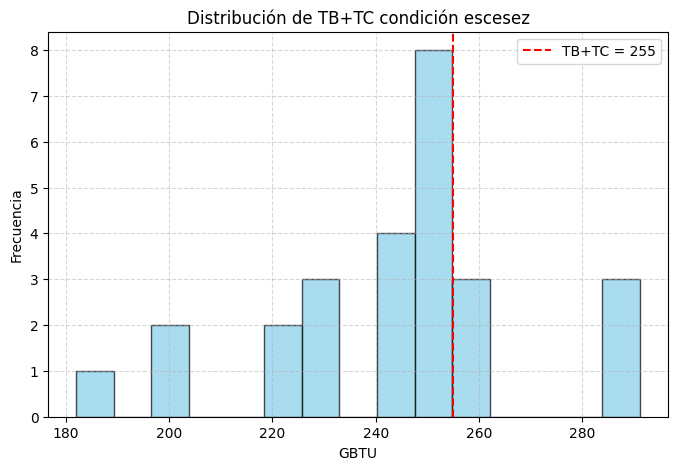

In [30]:
df_TEBSA_TC=df_data1[(df_data1['Con_Esc_Flag']==1)]

# Lectura de datos de enrtrada para el cálculo
s_parentpath=Path('C:\Alejo\EstadísticasConsumo')
filepath=s_parentpath.joinpath(s_parentpath,'DatosPrueba.xlsx')

# Carga del nivel probabilístico del embalse
sheet_name='Fechas'
df_Fecha=pd.read_excel(filepath, header=0,sheet_name=sheet_name)

# Eliminar del dataframe df_TEBSA_TC las fechas que están en la columna Fecha de df_Fecha
df_TEBSA_TC = df_TEBSA_TC[~df_TEBSA_TC['Date'].isin(df_Fecha['Fecha'])]
df_TEBSA_TC = df_TEBSA_TC.reset_index(drop=True)


# Calcular la probabilidad y el número de veces que TEBSA supera 155
num_supera_255 = (df_TEBSA_TC['TB+TC'] > 255).sum()
total_registros = len(df_TEBSA_TC)
prob_supera_255= num_supera_255 / total_registros if total_registros > 0 else 0

print(f"Total Registros: {total_registros}")
print(f"Número de veces que TB+TC supera 255: {num_supera_255}")
print(f"Probabilidad de que TB+TC supere 255: {prob_supera_255:.4f}")

# Gráfica de distribución
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(df_TEBSA_TC['TB+TC'], bins=15, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(255, color='red', linestyle='--', label='TB+TC = 255')
plt.title('Distribución de TB+TC condición escesez')
plt.xlabel('GBTU')
plt.ylabel('Frecuencia')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()